# Assignment 7

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy
import pystan
import random
import pandas as pd
import itertools

from __future__ import division
from pylab import * # this line will import math and plot functions that I may need

In [3]:
# Load HDI function
def HDIofMCMC(SampleArray, credMass=.95): #Computes the HDI from an array of a unimodal samples of representative values.
    sortedarray=np.sort(SampleArray)
    CielingIndex=np.ceil(credMass*np.size(sortedarray))
    nCI=np.size(sortedarray)-CielingIndex
    ciWidth=np.zeros(int(nCI))
    for i in range(int(nCI)):
        ciWidth[i]=sortedarray[i+int(CielingIndex)]-sortedarray[i]
    HDImin=(sortedarray[np.argmin(ciWidth)])
    HDImax=(sortedarray[np.argmin(ciWidth)+int(CielingIndex)])
    HDIlim=np.array([HDImin,HDImax])
    return(HDIlim)

## Objectives
1.&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; See if there the reaction time is dependent on the attempt number, e.g., are we reacting faster (or slower) in consecutive attempts?

2.&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Is there a difference between adults and kids? For the average reaction time we did show in Assignment 6 that there is a difference, but is there a difference in how much faster we are doing in consecutive attempts? (For example: do kids learn faster than adults?)   


As before I start by implementing the model in pySTAN.

In [4]:
#Importing data
y = np.array((607, 583, 521, 494, 369, 782, 570, 678, 467, 620, 425, 395, 346, 361, 310, 300, 382, 294, 315, 323, 421, 339, 398, 328, 335, 291, 329, 310, 294, 321, 286, 349, 279, 268, 293, 310, 259, 241, 243, 272, 247, 275, 220, 245, 268, 357, 273, 301, 322, 276, 401, 368, 149, 507, 411, 362, 358, 355, 362, 324, 332, 268, 259, 274, 248, 254, 242, 286, 276, 237, 259, 251, 239, 247, 260, 237, 206, 242, 361, 267, 245, 331, 357, 284, 263, 244, 317, 225, 254, 253, 251, 314, 239, 248, 250, 200, 256, 233, 427, 391, 331, 395, 337, 392, 352, 381, 330, 368, 381, 316, 335, 316, 302, 375, 361, 330, 351, 186, 221, 278, 244, 218, 126, 269, 238, 194, 384, 154, 555, 387, 317, 365, 357, 390, 320, 316, 297, 354, 266, 279, 327, 285, 258, 267, 226, 237, 264, 510, 490, 458, 425, 522, 927, 555, 550, 516, 548, 560, 545, 633, 496, 498, 223, 222, 309, 244, 207, 258, 255, 281, 258, 226, 257, 263, 266, 238, 249, 340, 247, 216, 241, 239, 226, 273, 235, 251, 290, 473, 416, 451, 475, 406, 349, 401, 334, 446, 401, 252, 266, 210, 228, 250, 265, 236, 289, 244, 327, 274, 223, 327, 307, 338, 345, 381, 369, 445, 296, 303, 326, 321, 309, 307, 319, 288, 299, 284, 278, 310, 282, 275, 372, 295, 306, 303, 285, 316, 294, 284, 324, 264, 278, 369, 254, 306, 237, 439, 287, 285, 261, 299, 311, 265, 292, 282, 271, 268, 270, 259, 269, 249, 261, 425, 291, 291, 441, 222, 347, 244, 232, 272, 264, 190, 219, 317, 232, 256, 185, 210, 213, 202, 226, 250, 238, 252, 233, 221, 220, 287, 267, 264, 273, 304, 294, 236, 200, 219, 276, 287, 365, 438, 420, 396, 359, 405, 397, 383, 360, 387, 429, 358, 459, 371, 368, 452, 358, 371))
ind = np.array((1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 30, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 33, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34))-1
#523->323 to Change back "the dude"

In [5]:
#Indicators that could be used depending on how the grouping is implemented
child_j = [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
child_i = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [6]:
#Attempt number for individual attempt.
x = np.array([1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1, 2, 3, 4, 5, 6, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1, 2, 3, 4, 5, 6, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18])

I copy and change the code from assignment 6. I select to use Gelman's implementation as I find it more intuitive than Kruschke's solution.

In [ ]:
close('all')


## Stan implementation
ass7_code = """
data {
    int<lower=0> NInd; //Number of participants
    int<lower=0> Samples; // number of samples, integer with a lower bound = 0  
    real<lower=0> y[Samples]; // Vector of samples, y with length "Samples" of real values
    int Ind[Samples];
    real child_j[NInd];
    int x[Samples];
}
parameters {
    real mu0;
    real mu1;
    real<lower=0> tau0;
    real<lower=0> tau1;
    real theta0[NInd];
    real theta1[NInd];
    real<lower=0> sigma;
    real phi0; //predictor parameter
    real phi1; //predictor parameter
}
transformed parameters {
}
model {
    mu0 ~ uniform(-10000, 10000); // Flat prior distribution on mu0
    mu1 ~ uniform(-10000, 10000); // Flat prior distribution on mu1
    // tau0 ~ uniform(0, 10000); // Flat prior distribution on tau0
    // tau1 ~ uniform(0, 10000); // Flat prior distribution on tau1
    phi0 ~ uniform(-10000, 10000); // Flat prior distribution on phi0
    phi1 ~ uniform(-10000, 10000); // Flat prior distribution on phi1
    for (i in 1:NInd)    
        theta0[i] ~ normal(mu0 + phi0*child_j[i], tau0); // Group level prior distribution of theta
    for (j in 1:NInd)
        theta1[j] ~ normal(mu1 + phi1*child_j[j], tau1);
    sigma ~ uniform(0, 10000); // Flat prior distribution on sigma
    for (k in 1:Samples)
        y[k] ~ lognormal(theta0[Ind[k]] + theta1[Ind[k]]*x[k], sigma); // likelihood, i.e collected data. Note that stan will create the posterior automatically. 
}
"""


ass7_dat = {'Ind': ind+1, #Individual index, +1 is correcting the indexing to start from 1 for the C++ compilation
            'NInd': np.max(ind)+1, #Total number of individuals
            'child_j': child_j, #Indexing, 1 if child, 0 if not
            'Samples': np.size(y), #Total number of samples
            'x': x, #Number of attempts for each reaction time value
            'y': y} #Measured reaction times

model = pystan.StanModel(model_code=ass7_code) #Create a model instance


In [ ]:
fit = model.sampling(data=ass7_dat,iter=100000,warmup=5000, chains=, control={'adapt_delta':0.9}) #Call the sampling using the model instance

In [ ]:
#fit
fit.plot('tau1')

This did not work. I got the following error: 

WARNING:pystan:8268 of 95000 iterations ended with a divergence (8.7 %).

WARNING:pystan:Try running with adapt_delta larger than 0.9 to remove the divergences.

WARNING:pystan:Chain 1: E-BFMI = 0.131

WARNING:pystan:E-BFMI below 0.2 indicates you may need to reparameterize your model 

I tried increasing the warmup steps x10 and increasing the "adapt_delta" parameter which corresponds to decreasing the step size of the HMC algorithm, neigther helped. What is left to do is to try reparametrization. I create a new modelling instance.

In [7]:
close('all')

## Stan implementation
ass7b_code = """
data {
    int<lower=0> NInd; //Number of participants
    int<lower=0> Samples; // number of samples, integer with a lower bound = 0  
    real y[Samples]; // Vector of samples, y with length "Samples" of real values
    int Ind[Samples];
    real child_j[NInd];
    real x[Samples];
}
parameters {
    real mu0;
    real mu1;
    real<lower=0> tau0;
    real<lower=0> tau1;
    real<lower=0> sigma;
    real phi0; //predictor parameter
    real phi1; //predictor parameter
    real eta0[NInd];
    real eta1[NInd];
}
transformed parameters { //Reparametrization
    real theta0[NInd];          // intercept for each individual
    real theta1[NInd];          // slope for each individual
    for (i in 1:NInd) {
        theta0[i] =mu0+phi0*child_j[i]+tau0*eta0[i];
        theta1[i] =mu1+phi1*child_j[i]+tau1*eta1[i];
    }
}
model {
    mu0 ~ uniform(-10000, 10000); // Flat prior distribution on mu0
    mu1 ~ uniform(-10000, 10000); // Flat prior distribution on mu1
    tau0 ~ uniform(0, 10000); // Flat prior distribution on tau0
    tau1 ~ uniform(0, 10000); // Flat prior distribution on tau1
    phi0 ~ uniform(-10000, 10000); // Flat prior distribution on phi0
    phi1 ~ uniform(-10000, 10000); // Flat prior distribution on phi1
    for (j in 1:NInd) {
        eta0[j] ~ normal(0,1); //Reparametrization Parameter
        eta1[j] ~ normal(0,1);
    }
    sigma ~ uniform(0, 10000); // Flat prior distribution on sigma
    for (k in 1:Samples)
        y[k] ~ lognormal(theta0[Ind[k]] + theta1[Ind[k]]*x[k], sigma); // likelihood, i.e collected data. Note that stan will create the posterior automatically. 
}
"""


ass7b_dat = {'Ind': ind+1, #Individual index, +1 is correcting the indexing to start from 1 for the C++ compilation
            'NInd': np.max(ind)+1, #Total number of individuals
            'child_j': child_j, #Indexing, 1 if child, 0 if not
            'Samples': np.size(y), #Total number of samples
            'x': x, 
            'y': y }

modelb = pystan.StanModel(model_code=ass7b_code) #Create a model instance

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c2c95ab7cb89c5065281708dd7942f40 NOW.


In [8]:
fitb = modelb.sampling(data=ass7b_dat,iter=100000,warmup=1000, chains=2, control={'adapt_delta':0.85}) #Call the sampling using the model instance

In [148]:
print(fitb)

Inference for Stan model: anon_model_c2c95ab7cb89c5065281708dd7942f40.
2 chains, each with iter=100000; warmup=1000; thin=1; 
post-warmup draws per chain=99000, total post-warmup draws=198000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu0          5.71  2.9e-4   0.05   5.61   5.68   5.71   5.74    5.8  27558    1.0
mu1       -7.9e-3  6.0e-6 2.6e-3  -0.01-9.6e-3-7.9e-3-6.2e-3-2.7e-3 194295    1.0
tau0         0.22  1.5e-4   0.03   0.17    0.2   0.22   0.24   0.29  45510    1.0
tau1       4.4e-3  1.3e-5 2.9e-3 2.3e-4 2.1e-3 4.0e-3 6.1e-3   0.01  47638    1.0
sigma        0.15  1.5e-5 6.3e-3   0.13   0.14   0.15   0.15   0.16 181162    1.0
phi0         0.46  4.9e-4    0.1   0.27    0.4   0.46   0.52   0.65  38258    1.0
phi1        -0.02  1.8e-5 8.3e-3  -0.04  -0.03  -0.02  -0.02-8.1e-3 200160    1.0
eta0[1]      0.68  1.8e-3   0.44  -0.18   0.38   0.68   0.98   1.57  63121    1.0
eta0[2]      1.48  1.9e-3   0.47   0.59   1.16   1.47   1.79   2.42 

Even after the reparametrization stand still warned about divergence. I increased the "adapt_delta" parameter to decrease step length and this problem dissappeared.

# 1.
$\theta_0$ and $\theta_1$ in this model are parameters that describe a credible relationship between the predictor (the number of attempts) and the predicted variable (reaction time) for every individal. This relationship will be linear in log space with $\theta_0$ as the intercept (reaction time at attempt "0") and $\theta_1$ as the slope (how much does the reaction time change for each try). There will be many possible combinations of  $\theta_0$ and $\theta_1$ that are credible but have different values. In order to describe this variation we also have a standard deviation parameter $\sigma$. In this model the noise is concidered to be the same for different number of attempts which might not be the true situation.  

# 2.
$\mu_0$, $\phi_0$, $\mu_1$ and $\phi_1$ are the hyper parameters in our model. That means that they are parameters that describe our likelihood parameters $\theta_0$ and $\theta_1$.  

$\mu_0$ is the average value of $\theta_0$ for the adult group. Since $\theta_0$ is the reaction time at 0 tries for specific individuals (children or adults) $\mu_0$ represents the average reaction time of an adult that has never seen the game. This is technically a lie since it is impossible to measure the reaction time a 0 tries so this number is just an effect of the model and not very interesting to analyse.

$\phi_0$ is the shift of the average $\theta_0$ value between the adult group and the child group. Since the reaction time is given by the exponential of the parameters of the model and exp($\mu_0$+$\phi_0$)=exp($\mu_0$)exp($\phi_0$) it is also possible to say that exp($\phi_0$) gives the percental factor by which the reaction time differs between children and adults. This difference is independent of the number of tries.

$\mu_1$ is the average value of $\theta_1$ for the adult group. Since $\theta_1$ is the rate of change (slope) with increasing number of attempts $\mu_1$ represents the average trend of the "improvment" of the adult group. If $\mu_1$ is positive adult reaction times are getting worse and if $\mu_1$ is negative adult reaction times are getting better with increased numbers of attempts.

Finally $\phi_0$ is the change in rate of change between the adult and child groups. If $\phi_0$ is positive children are learning slower than adults. If $\phi_0$ is negative children are learning faster than adults.


In [9]:
results=fitb.extract(permuted=True) # return a dictionary of arrays with the sampled parameter data

In [10]:
#Extracting resulting parameter values
Phi0=results['phi0'] 
Phi1=results['phi1']
sigma=results['sigma']
Tau0=results['tau0']
Tau1=results['tau1']
mu0=results['mu0']
mu1=results['mu1']
theta0=results['theta0']
theta1=results['theta1']

In [11]:
np.size(theta1[0,:])

34

## 3.
Provide the expected reaction time for the first attempt (x=1) and the fifth attempt (x=5) for the first individual (Oliver), third individual (Jesper) and fourth individual (“the dude”)

In order to answer this question I plot the histogram of the expected reaction time $E(y_i)$ as calculated from the individual level parameters in assignment 6. $E(y_i)=\theta_{0i}+\theta_{1i}*x+\frac{\sigma^2}{2}$

## Plots of reaction times

In [149]:
Ey_Oliver=np.zeros((2,np.size(sigma))) #Pre-allocation of expected value and reaction time arrays
Ey_Jesper=np.zeros((2,np.size(sigma)))
Ey_TheDude=np.zeros((2,np.size(sigma)))


#Attempts
x=[1,5]  
Ind=[0,2,3] #Individual index 
for i in (0,1):
    Ey_Oliver[i,:]=exp(theta0[:,Ind[0]]+theta1[:,Ind[0]]*x[i]+sigma**2/2)
    Ey_Jesper[i,:]=exp(theta0[:,Ind[1]]+theta1[:,Ind[1]]*x[i]+sigma**2/2)
    Ey_TheDude[i,:]=exp(theta0[:,Ind[2]]+theta1[:,Ind[2]]*x[i]+sigma**2/2)

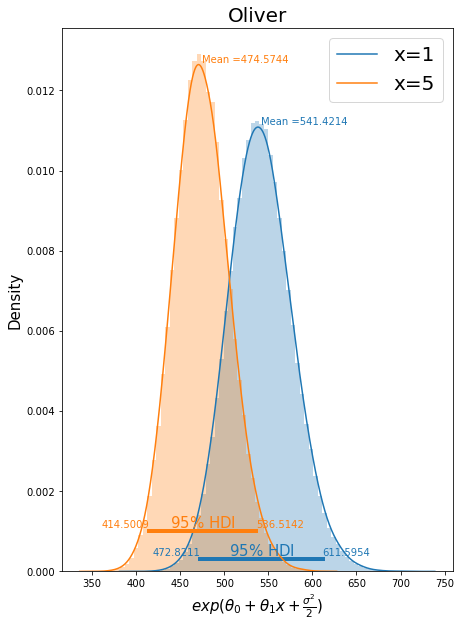

In [150]:
#Plotting
fig= plt.figure(figsize=(7,10))
#Plot Oliver
binsize_Oliver=np.linspace(np.min(Ey_Oliver),np.max(Ey_Oliver),int(((np.max(Ey_Oliver)-np.min(Ey_Oliver))/5)))

Color=('tab:blue','tab:orange')
HDI_Height=((0.0003,0.0003),(0.001,0.001))

for i in (0,1):
    plt.hist(Ey_Oliver[i,:],binsize_Oliver,density=True,alpha=.3,color=Color[i])
   
    #False smooth density plot, code I found online...
    density = scipy.stats.gaussian_kde(Ey_Oliver[i,:])
    xs = np.linspace(min(Ey_Oliver[i,:]),max(Ey_Oliver[i,:]),1000)
    density.covariance_factor = lambda : .2
    density._compute_covariance()
    plt.plot(xs,density(xs),color=Color[i],label='x='+str(x[i]))
    
    #HDI
    HDI_x=HDIofMCMC(Ey_Oliver[i,:],.95)
    plt.plot(HDI_x,HDI_Height[i],color=Color[i],linewidth=4.0)
    plt.text(np.mean(HDI_x), HDI_Height[i][i]+0.0001, r'$95\%$ HDI', color=Color[i], fontsize=15,ha='center') #Plots text in the figure
    plt.text(HDI_x[0], HDI_Height[i][i]+0.0001, str(np.round(HDI_x[0],4)), color=Color[i], fontsize=10,ha='right')
    plt.text(HDI_x[1], HDI_Height[i][i]+0.0001, str(np.round(HDI_x[1],4)), color=Color[i], fontsize=10,ha='left')
    plt.text(np.mean(Ey_Oliver[i,:]),np.max(density(xs)),'Mean ='+str(np.round(np.mean(Ey_Oliver[i,:]),4)),color=Color[i],va='bottom',ha='left')
    
plt.xlabel(r'$exp(\theta_0+\theta_1x+\frac{\sigma^2}{2}$)',fontsize=15)
plt.ylabel('Density',fontsize=15)
plt.title('Oliver',fontsize=20)
plt.legend(fontsize=20)
plt.savefig('Oliver1.png')

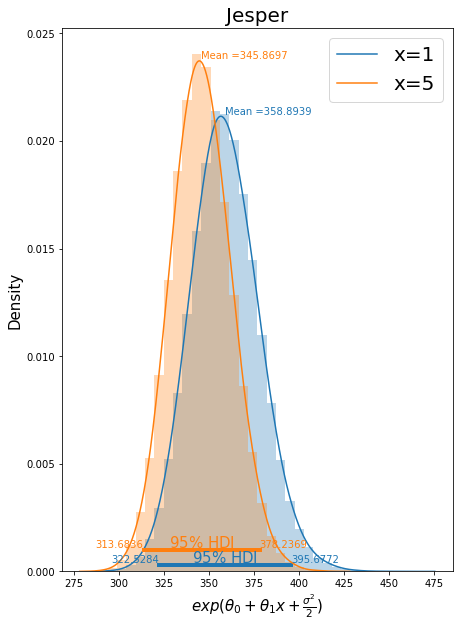

In [151]:
#Plotting
fig= plt.figure(figsize=(7,10))
#Plot Jesper
binsize_Jesper=np.linspace(np.min(Ey_Jesper),np.max(Ey_Jesper),int(((np.max(Ey_Jesper)-np.min(Ey_Jesper))/5)))

Color=('tab:blue','tab:orange')
HDI_Height=((0.0003,0.0003),(0.001,0.001))

for i in (0,1):
    plt.hist(Ey_Jesper[i,:],binsize_Jesper,density=True,alpha=.3,color=Color[i])
   
    #False smooth density plot, code I found online...
    density = scipy.stats.gaussian_kde(Ey_Jesper[i,:])
    xs = np.linspace(min(Ey_Jesper[i,:]),max(Ey_Jesper[i,:]),1000)
    density.covariance_factor = lambda : .2
    density._compute_covariance()
    plt.plot(xs,density(xs),color=Color[i],label='x='+str(x[i]))
    
    #HDI
    HDI_x=HDIofMCMC(Ey_Jesper[i,:],.95)
    plt.plot(HDI_x,HDI_Height[i],color=Color[i],linewidth=4.0)
    plt.text(np.mean(HDI_x), HDI_Height[i][i]+0.0001, r'$95\%$ HDI', color=Color[i], fontsize=15,ha='center') #Plots text in the figure
    plt.text(HDI_x[0], HDI_Height[i][i]+0.0001, str(np.round(HDI_x[0],4)), color=Color[i], fontsize=10,ha='right')
    plt.text(HDI_x[1], HDI_Height[i][i]+0.0001, str(np.round(HDI_x[1],4)), color=Color[i], fontsize=10,ha='left')
    plt.text(np.mean(Ey_Jesper[i,:]),np.max(density(xs)),'Mean ='+str(np.round(np.mean(Ey_Jesper[i,:]),4)),color=Color[i],va='bottom',ha='left')
    
plt.xlabel(r'$exp(\theta_0+\theta_1x+\frac{\sigma^2}{2}$)',fontsize=15)
plt.ylabel('Density',fontsize=15)
plt.title('Jesper',fontsize=20)
plt.legend(fontsize=20)
plt.savefig('Jesper1.png')

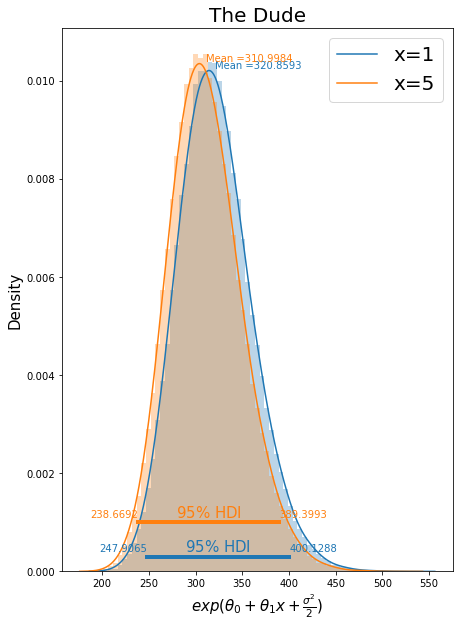

In [152]:
#Plotting
fig= plt.figure(figsize=(7,10))
#Plot The Dude
binsize_TheDude=np.linspace(np.min(Ey_TheDude),np.max(Ey_TheDude),int(((np.max(Ey_TheDude)-np.min(Ey_TheDude))/5)))

Color=('tab:blue','tab:orange')
HDI_Height=((0.0003,0.0003),(0.001,0.001))

for i in (0,1):
    plt.hist(Ey_TheDude[i,:],binsize_TheDude,density=True,alpha=.3,color=Color[i])
   
    #False smooth density plot, code I found online...
    density = scipy.stats.gaussian_kde(Ey_TheDude[i,:])
    xs = np.linspace(min(Ey_TheDude[i,:]),max(Ey_TheDude[i,:]),1000)
    density.covariance_factor = lambda : .2
    density._compute_covariance()
    plt.plot(xs,density(xs),color=Color[i],label='x='+str(x[i]))
    
    #HDI
    HDI_x=HDIofMCMC(Ey_TheDude[i,:],.95)
    plt.plot(HDI_x,HDI_Height[i],color=Color[i],linewidth=4.0)
    plt.text(np.mean(HDI_x), HDI_Height[i][i]+0.0001, r'$95\%$ HDI', color=Color[i], fontsize=15,ha='center') #Plots text in the figure
    plt.text(HDI_x[0], HDI_Height[i][i]+0.0001, str(np.round(HDI_x[0],4)), color=Color[i], fontsize=10,ha='right')
    plt.text(HDI_x[1], HDI_Height[i][i]+0.0001, str(np.round(HDI_x[1],4)), color=Color[i], fontsize=10,ha='left')
    plt.text(np.mean(Ey_TheDude[i,:]),np.max(density(xs)),'Mean ='+str(np.round(np.mean(Ey_TheDude[i,:]),4)),color=Color[i],va='bottom',ha='left')
    
plt.xlabel(r'$exp(\theta_0+\theta_1x+\frac{\sigma^2}{2}$)',fontsize=15)
plt.ylabel('Density',fontsize=15)
plt.title('The Dude',fontsize=20)
plt.legend(fontsize=20)
plt.savefig('TheDude1.png')

## Plot of credible regression lines

### Oliver

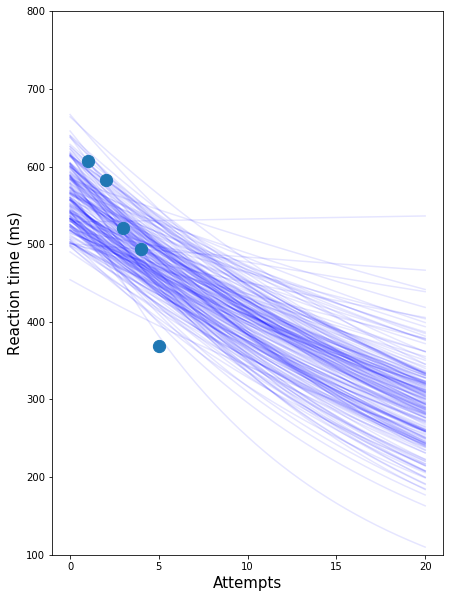

In [153]:
fig= plt.figure(figsize=(7,10))
#Oliver
for i in range(200): #plot 150 credible regression lines
    Index=randint(np.size(sigma))
    y_credible=exp(theta0[:,Ind[0]][Index] + theta1[:,Ind[0]][Index] * attempt + sigma[Index]**2/2)
    plt.plot(attempt,y_credible,'-b',alpha=.1)
## Data plot
ind_index=np.where(ind==Ind[0]) #0 as index for for Oliver
plt.scatter(np.arange(np.size(ind_index[0]))+1,y[list(ind_index[0])],color=Color[0], marker='o',s=150, zorder=10)
attempt=np.linspace(0,20,np.size(sigma))

plt.xlabel(r'Attempts',fontsize=15)
plt.ylabel('Reaction time (ms)',fontsize=15)
plt.xticks([0,5,10,15,20])
plt.ylim(100, 800) #To keep the scale constant between figures
plt.savefig('Oliver2.png')

### Jesper

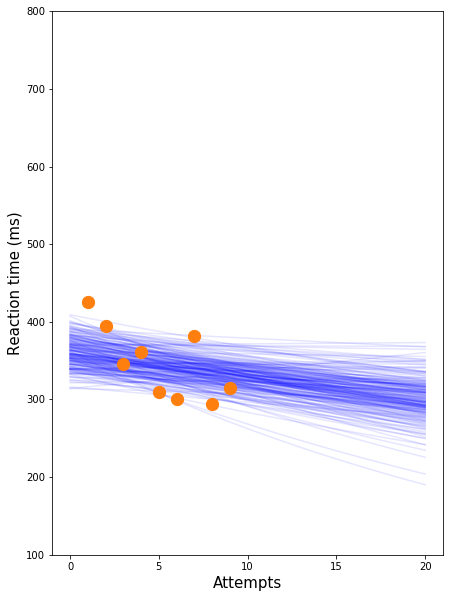

In [154]:
fig= plt.figure(figsize=(7,10))
#Jesper
for i in range(200): #plot 150 credible regression lines
    Index=randint(np.size(sigma))
    y_credible=exp(theta0[:,Ind[1]][Index] + theta1[:,Ind[1]][Index] * attempt + sigma[Index]**2/2)
    plt.plot(attempt,y_credible,'-b',alpha=.1)
## Data plot
ind_index=np.where(ind==Ind[1]) #1 as index for for Jesper
plt.scatter(np.arange(np.size(ind_index[0]))+1,y[list(ind_index[0])],color=Color[1], marker='o',s=150, zorder=10)
attempt=np.linspace(0,20,np.size(sigma))

plt.xlabel(r'Attempts',fontsize=15)
plt.ylabel('Reaction time (ms)',fontsize=15)
plt.xticks([0,5,10,15,20])
plt.ylim(100, 800) #To keep the scale constant between figures
plt.savefig('Jesper2.png')

### The Dude

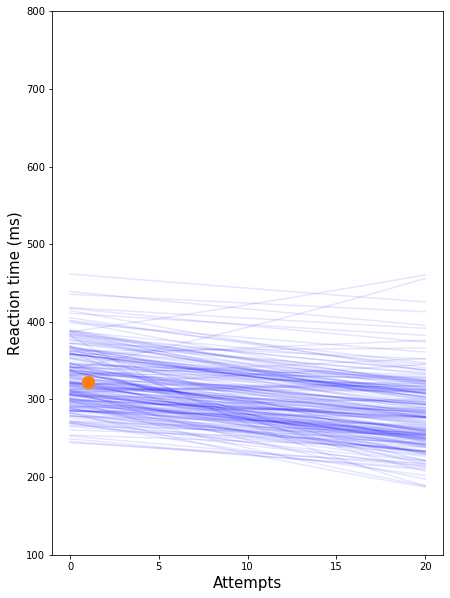

In [155]:
fig= plt.figure(figsize=(7,10))
#Jesper
for i in range(200): #plot 150 credible regression lines
    Index=randint(np.size(sigma))
    y_credible=exp(theta0[:,Ind[2]][Index] + theta1[:,Ind[2]][Index] * attempt + sigma[Index]**2/2)
    plt.plot(attempt,y_credible,'-b',alpha=.1)
## Data plot
ind_index=np.where(ind==Ind[2]) # as index for for Jesper
plt.scatter(np.arange(np.size(ind_index[0]))+1,y[list(ind_index[0])],color=Color[1], marker='o',s=150, zorder=10)
attempt=np.linspace(0,20,np.size(sigma))

plt.xlabel(r'Attempts',fontsize=15)
plt.ylabel('Reaction time (ms)',fontsize=15)
plt.xticks([0,5,10,15,20])
plt.ylim(100, 800) #To keep the scale constant between figures
plt.savefig('TheDude2.png')

## 4.

Discuss possible model improvements to our model. 
### What would happen if x goes to infinity? 
If x goes to infinity we would see an asymptotic decay towards a reaction time of 0 for most of the credible regression lines. Only a few posterior samples does not show this behaviour and for indiviuals with more than one recorded attempt this seems to be the typical behaviour of the model. As stated above this is not a realistic behaviour and may have to be corrected. This could be done by adding an asymptotic constant (exp(x)+100)) that changes the lowest reaction time to a realistic minimum.  
### It seems like there is no way to get a reaction time less than 100ms looking at the website and our data. Is this physically realistic?
No, that is not physically realistic
### How can we improve the model?
One way that the model could be improved is as discussed in chapter 19 of the book by adding a layer in the heirarchy by adding hyperparameter and hyper priors to the sigma parameter. As is right now the sigma parameter is the most accomodating parameter in the model as is needs to accomodate information from both groups (children and adults) and for every number of attempts. The hyperparameters and hyperpriors that are added could depend on the number of attempts just like the $\theta_i$ parameters do in the current model. This could likely improve the tightness of the credible regression lines for all individals. 

As was discussed in class, another way to improve the model could be to model the reaction time as a higher order polynomial on x. I'm uncertain if this would improve the fit though as the expected behaviour to me would be something like the exponential decay that we get from most of the credible regression lines at the individual level (except for the dude where we have very little information). Using a higher order polynomial would maybe introduce unnecessary complexity as in the example in chapter 17 in the book (figure 17.8). 
### Should we change distributions (likelihood, priors)? What options do we have and why?
This to me seems like a better approach than to change the model parameters themselves. 

The likelihood could be changed to a t-distribution as in the book example in chapter 19. This might not be necessary though as it seems like we do not have outliers to the extent that it would add to the model. Looking at the reaction time data from the web page it could also be envisioned that a left-scewed distribution should be used instead to more accurately represent the recorded data (likelihood). 


## 5. 

### Notice that your sigma has decreased in Assignment 7, but are the same in 6 and 5. Why is that do you think?
This is because sigma needs to accomodate less information in the model than in the ones used in assignment 5 and 6. The difference is that the previous models did not account for the number of attempts (x) at each data point. One could aslo think about it as if the regression lines in the previous assignments were horisontal. Since the likelihood used horisontal lines to describe decaying values sigma needed to be larger.

## 6. 


$\sigma$